In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.applications import ResNet50
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/heythere/Christ/NNDL/NIH_Project/data/sample/sample_labels.csv')

df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [3]:
df["Finding Labels"] = df["Finding Labels"].str.split('|')

In [4]:
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,"[Emphysema, Infiltration, Pleural_Thickening, ...",5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,"[Cardiomegaly, Emphysema]",26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,[No Finding],1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,[Atelectasis],1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,"[Cardiomegaly, Edema, Effusion]",1,32,055Y,F,AP,2500,2048,0.168,0.168


In [5]:
mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(df["Finding Labels"])
classes = mlb.classes_

if "No Finding" in mlb.classes_:
    idx = list(mlb.classes_).index("No Finding")
    labels = np.delete(labels, idx, axis=1)
    classes = [c for c in mlb.classes_ if c != "No Finding"]

In [7]:
from pathlib import Path

X_paths = df["Image Index"].apply(lambda x: str(Path("/Users/heythere/Christ/NNDL/NIH_Project/data/sample/images") / x)).values
groups = df["Patient ID"].values

In [8]:
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X_paths, labels, groups=groups))
X_tr, X_val = X_paths[train_idx], X_paths[val_idx]
labels_tr, labels_val = labels[train_idx], labels[val_idx]

In [9]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)      # grayscale
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.clip_by_value(img / 255.0, 0.0, 1.0)
    img = tf.image.grayscale_to_rgb(img)            # 3ch for ImageNet backbones
    return img, label

def augment(img, label):
    img = tf.image.random_brightness(img, 0.05)
    img = tf.image.random_contrast(img, 0.95, 1.05)
    img = tf.image.random_flip_left_right(img)
    return img, label

def make_ds(X, Y, training=True, batch=32):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    ds = ds.shuffle(len(X)) if training else ds
    ds = ds.map(load_image, num_parallel_calls=AUTOTUNE)
    if training: ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    return ds.batch(batch).prefetch(AUTOTUNE)

train_ds = make_ds(X_tr, labels_tr, training=True, batch=32)
val_ds   = make_ds(X_val, labels_val, training=False, batch=32)

2025-08-18 19:54:44.845402: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-08-18 19:54:44.845488: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-08-18 19:54:44.845499: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-08-18 19:54:44.846470: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-18 19:54:44.846491: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [10]:
def build_densenet(input_shape=(224,224,3), num_classes=14):
    base = DenseNet121(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False   # freeze backbone first
    
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)
    
    model = tf.keras.Model(base.input, out)
    return model

In [11]:
def build_resnet(input_shape=(224,224,3), num_classes=14):
    base = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    base.trainable = False
    
    x = tf.keras.layers.GlobalAveragePooling2D()(base.output)
    x = tf.keras.layers.Dropout(0.3)(x)
    out = tf.keras.layers.Dense(num_classes, activation="sigmoid")(x)
    
    model = tf.keras.Model(base.input, out)
    return model


In [12]:
def compile_and_train(model, train_ds, val_ds, epochs=3):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(multi_label=True, num_labels=14)]
    )
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)
    return history


In [13]:
densenet = build_densenet()
hist_d = compile_and_train(densenet, train_ds, val_ds)

resnet = build_resnet()
hist_r = compile_and_train(resnet, train_ds, val_ds)


Epoch 1/3


2025-08-18 19:54:50.021352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


140/140 ━━━━━━━━━━━━━━━━━━━━ 144s 956ms/step - auc: 0.5180 - loss: 0.2897 - val_auc: 0.5809 - val_loss: 0.1798
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - auc: 0.5544 - loss: 0.1880 - val_auc: 0.6046 - val_loss: 0.1761
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - auc: 0.5929 - loss: 0.1817 - val_auc: 0.6383 - val_loss: 0.1752
Epoch 1/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 148s 1s/step - auc_1: 0.4695 - loss: 0.3112 - val_auc_1: 0.5269 - val_loss: 0.1821
Epoch 2/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 130s 932ms/step - auc_1: 0.5027 - loss: 0.1864 - val_auc_1: 0.5208 - val_loss: 0.1818
Epoch 3/3
140/140 ━━━━━━━━━━━━━━━━━━━━ 107s 764ms/step - auc_1: 0.5013 - loss: 0.1827 - val_auc_1: 0.5246 - val_loss: 0.1825


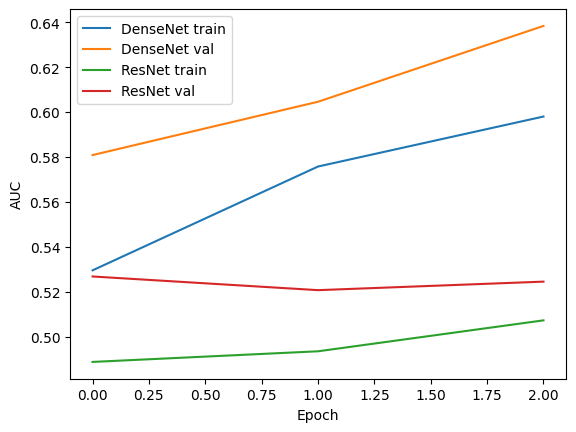

In [19]:
def plot_history(hist1, hist2, label1="DenseNet", label2="ResNet"):
    # Grab metric names dynamically (ignoring 'loss')
    m1 = [k for k in hist1.history.keys() if not k.startswith("val") and k != "loss"][0]
    m2 = [k for k in hist2.history.keys() if not k.startswith("val") and k != "loss"][0]

    plt.plot(hist1.history[m1], label=f"{label1} train")
    plt.plot(hist1.history["val_" + m1], label=f"{label1} val")
    plt.plot(hist2.history[m2], label=f"{label2} train")
    plt.plot(hist2.history["val_" + m2], label=f"{label2} val")
    plt.xlabel("Epoch")
    plt.ylabel("AUC")
    plt.legend()
    plt.show()

plot_history(hist_d, hist_r)

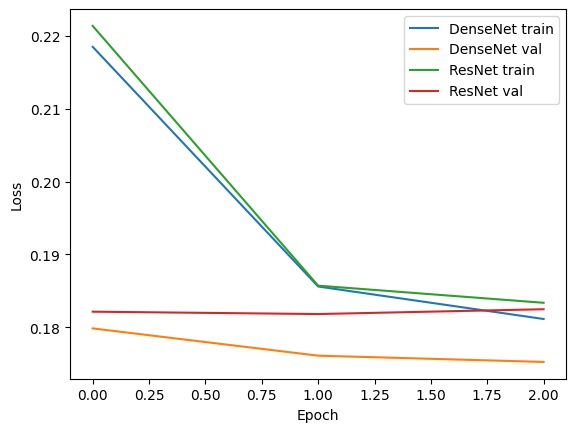

In [20]:
def plot_loss(hist1, hist2, label1="DenseNet", label2="ResNet"):
    plt.plot(hist1.history["loss"], label=f"{label1} train")
    plt.plot(hist1.history["val_loss"], label=f"{label1} val")
    plt.plot(hist2.history["loss"], label=f"{label2} train")
    plt.plot(hist2.history["val_loss"], label=f"{label2} val")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_loss(hist_d, hist_r)
